# 推薦系統-Collaborative filtering for three methods

# part_1 try to find more features

◆ 由於有metadata及ratings的資料可使用，之前尚未針對metadata中部分欄位做研究，故此次先以嘗試的方式進行推薦

## 基礎建設

In [2]:
import pandas as pd
import gzip, json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 載入資料

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import datetime

In [3]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

--2022-01-09 13:02:00--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15499476 (15M) [application/octet-stream]
Saving to: ‘All_Beauty.csv’

All_Beauty.csv      100%[===================>]  14.78M  24.9MB/s    in 0.6s    

2022-01-09 13:02:00 (24.9 MB/s) - ‘All_Beauty.csv’ saved [15499476/15499476]

--2022-01-09 13:02:01--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10329961 (9.9M) [application/octet-stream]
Saving to: ‘meta_All_Beauty.json.gz’

meta_All_Beauty.jso 100%[===================>]   9.85M  19.1MB/s    in 0.5s    

202

In [4]:
# colab
metadata = getDF('/content/meta_All_Beauty.json.gz')
ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [ ]:
# 本地端
metadata = getDF('meta_All_Beauty.json.gz')
ratings = pd.read_csv('All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [ ]:
metadata.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [ ]:
# metadata資料清洗
metadata = metadata.applymap(lambda x: str(x).replace('[]','') if len(x)<1 else x)
metadata.replace('', np.nan, inplace = True)

In [ ]:
# 觀察空值分布狀況
metadata.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32892 entries, 0 to 32891
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   category         0 non-null      float64
 1   tech1            10 non-null     object 
 2   description      15119 non-null  object 
 3   fit              0 non-null      float64
 4   title            32891 non-null  object 
 5   also_buy         6597 non-null   object 
 6   tech2            0 non-null      float64
 7   brand            17219 non-null  object 
 8   feature          269 non-null    object 
 9   rank             32515 non-null  object 
 10  also_view        8132 non-null   object 
 11  details          32892 non-null  object 
 12  main_cat         32892 non-null  object 
 13  similar_item     1304 non-null   object 
 14  date             19 non-null     object 
 15  price            11459 non-null  object 
 16  asin             32892 non-null  object 
 17  imageURL    

In [ ]:
metadata_clean = metadata.drop_duplicates(['asin'])
metadata_clean = metadata_clean.reset_index(drop=True)
print(f'origin {len(metadata)}, data without duplicate {len(metadata_clean)}')

origin 32892, data without duplicate 32488


In [ ]:
metadata_clean['rank_num'] = metadata['rank'].str.split(expand=True)[0].str.replace(',','').fillna(99999999999)
metadata_clean['rank_num'] = pd.to_numeric(metadata_clean['rank_num'])
metadata_clean['rank_category'] = metadata_clean['rank'].str.split("in ", expand=True)[1].str.replace(r"\(","", regex=True).replace(r"\&amp;","&",regex=True)
metadata_clean['price_clean'] = metadata_clean["price"].str.split("$",expand = True)[1]
metadata_clean['price_clean'] = metadata_clean["price_clean"].str.replace(',', '')
metadata_clean['price_clean'] = metadata_clean["price_clean"].str.replace(' - ', '')
metadata_clean['price_clean'] = pd.to_numeric(metadata_clean['price_clean'])
metadata_clean.head(3)

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,rank_num,rank_category,price_clean
0,NaN,NaN,[Loud 'N Clear Personal Sound Amplifier allows...,NaN,Loud 'N Clear&trade; Personal Sound Amplifier,NaN,NaN,idea village,NaN,"2,938,573 in Beauty & Personal Care (",NaN,{'ASIN: ': '6546546450'},All Beauty,NaN,NaN,NaN,6546546450,NaN,NaN,2938573,Beauty & Personal Care,NaN
1,NaN,NaN,[No7 Lift & Luminate Triple Action Serum 50ml ...,NaN,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",NaN,NaN,NaN,"872,854 in Beauty & Personal Care (",NaN,"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",NaN,$44.99,7178680776,NaN,NaN,872854,Beauty & Personal Care,44.99
2,NaN,NaN,[No7 Stay Perfect Foundation now stays perfect...,NaN,No7 Stay Perfect Foundation Cool Vanilla by No7,NaN,NaN,No7,NaN,"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,NaN,NaN,$28.76,7250468162,NaN,NaN,956696,Beauty & Personal Care,28.76


In [ ]:
brand = metadata_clean["brand"].value_counts().rename_axis('brand_name').reset_index(name='counts')
brand

,brand_name,counts
0,VAGA,252
1,L'Oreal Paris,110
2,Betty Dain,82
3,EG GIFTS,79
4,Unknown,79
...,...,...
7857,St. Tropez,1
7858,Magnic,1
7859,HobaCare,1
7860,Wet Spray,1


In [ ]:
category = metadata_clean["rank_category"].value_counts().rename_axis('name').reset_index(name='counts')
category

,name,counts
0,Beauty & Personal Care,32015
1,Grocery & Gourmet Food,37
2,Health & Household,21
3,Toys & Games,3
4,Sports & Outdoors,3
5,Baby,2
6,"Clothing, Shoes & Jewelry",2
7,Home & Kitchen,1
8,Tools & Home Improvement,1
9,Automotive,1


In [ ]:
# 選擇所需欄位
# 其他欄位未選用原因：空值過多、類別多樣性低(多集中在某類商品)
metadata_part = metadata_clean[['price_clean','asin']]
metadata_part.head(3)

,price_clean,asin
0,NaN,6546546450
1,44.99,7178680776
2,28.76,7250468162


## 資料整理

In [ ]:
ratings.head()

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200


In [ ]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')

## 資料切分

In [ ]:
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

In [ ]:
# excluding items which do not in the metadata_part
ratings_trainings = ratings_trainings.merge(metadata_part, how = 'inner', on = 'asin').iloc[:, :6]
ratings_trainings

,asin,reviewerID,overall,unixReviewTime,DATE,price_clean
0,7414204790,A5TA1NJOC0PJ5,5.0,1457568000,2016-03-10,12.15
1,7414204790,A1TJICB7VLGQKL,5.0,1441065600,2015-09-01,12.15
2,7414204790,A80M2286B7STE,5.0,1412294400,2014-10-03,12.15
3,7414204790,A2TM2MAA8IT34U,5.0,1407369600,2014-08-07,12.15
4,7414204790,AQGWT465GTEJG,4.0,1402704000,2014-06-14,12.15
...,...,...,...,...,...,...
365625,B01HJ84SGM,A2FZ7C9H14T5HZ,5.0,1506988800,2017-10-03,55.63
365626,B01HJ84SGM,A1YQHF10YIMWOL,5.0,1503532800,2017-08-24,55.63
365627,B01HJ84SGM,A1IYJVHJSCR8DR,5.0,1496016000,2017-05-29,55.63
365628,B01HJ84SGM,A7WHO9ZFPHU2B,5.0,1494288000,2017-05-09,55.63


In [ ]:
# 觀察多數評分為4分以上
ratings_trainings.overall.value_counts()

5.0    224827
4.0     52065
1.0     39111
3.0     29420
2.0     20207
Name: overall, dtype: int64

Text(0.5, 1.0, 'Distribution of average rating')

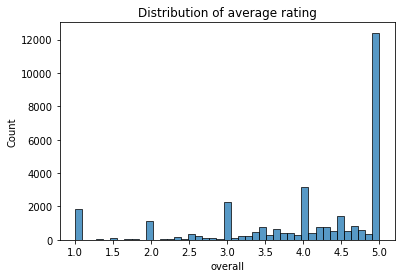

In [ ]:
ratings_trainings_rate = ratings_trainings.groupby(by = 'asin')[['overall']].mean()
sns.histplot(data = ratings_trainings_rate, x = 'overall')
plt.title('Distribution of average rating')

Text(0.5, 1.0, '# order per quarter')

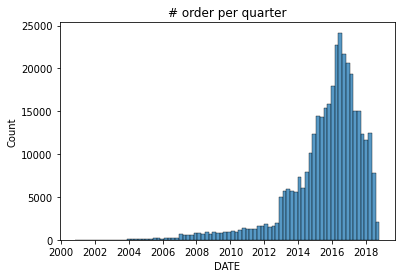

In [ ]:
# 消費日期集中在2015-2018
sns.histplot(data = ratings_trainings, x = 'DATE', binwidth = (80)) 
plt.title ('# order per quarter')

Text(0.5, 1.0, 'Distribution of price')

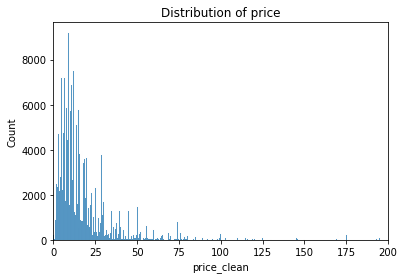

In [ ]:
# 產品價格集中在50USD以下
sns.histplot(data = ratings_trainings, x = 'price_clean')
plt.xlim(0, 200)
plt.title('Distribution of price')

◆ 在前兩次的作業中，已知道商品的銷售數量及時間會影響推薦率，尚未將price因素考量，故本次增加price因子的嘗試<br>
◆ 若商品價格的分佈不平均，篩選較常被購買的商品價格區間，是否會提高推薦率?

## 產生推薦

In [ ]:
# 考量價格做篩選之結果(單篩選價格=50)
import pandas as pd
from itertools import combinations
from collections import defaultdict

# header: user_id,item_id,rating,timestamp

def recommender(training_data, users=[], k=10):

    # loading data from dataframe
    # user_to_items dict:
    # {
    #   'user': {
    #       'item': ratings...
    #   }...
    # }
#-----new user------#----ruled-based-----#
#     ratings_trainings = training_data
    # set time period、price limit    
    split_date = '2018-08-01'
    split_price = 50
    condition_time = training_data[training_data['DATE']>=split_date]
    condition_price = condition_time[condition_time['price_clean']<=split_price]
    
    condition_all = condition_price.groupby(by = ['asin'], as_index=False).agg(buy_count=('asin', 'count'), rating_mean=('overall', 'mean')).sort_values(by=['buy_count', 'rating_mean'], ascending=[False, False])
    
    
#-----old user------#----cf-based-----#    
    user_to_items = defaultdict(dict)
    for _, row in training_data.iterrows():
        row = dict(row)
        user = row['reviewerID']
        item = row['asin']
        rating = float(row['overall'])

        user_to_items[user][item] = rating

    print("total users before filtering: ", len(user_to_items))

    # remove obscure user to decrease data size
    # filtering params
    remove_obscure_user = True
    user_rating_threshold = 3
    all_users = list(user_to_items.keys())
    for user in all_users:
        ratings = user_to_items[user]
        if remove_obscure_user and len(ratings) < user_rating_threshold:
            del user_to_items[user]

    print("total users  after filtering: ", len(user_to_items))

    # generate item to user mapping dict
    # {
    #   'item': {
    #       'user': ratings...
    #   }...
    # }
    item_to_users = defaultdict(dict)
    for user, items in user_to_items.items():
        for item, rating in items.items():
            item_to_users[item][user] = rating

    # prepare data of computing user similarity 
    init_sim = lambda: [0 for _ in range(3)]
    factory = lambda: defaultdict(init_sim)
    pre_user_similarity = defaultdict(factory)
    n = len(item_to_users)
    index = 0
    for item, user_ratings in item_to_users.items():
        if len(user_ratings) > 1:
            # print(f"item: {item} have been rated by {len(user_ratings)} users progress: {index}/{n}")
            for user1, user2 in combinations(user_ratings.keys(), 2):
                xy = user_ratings[user1] * user_ratings[user2]
                xx = user_ratings[user1] ** 2
                yy = user_ratings[user2] ** 2
                pre_user_similarity[user1][user2][0] += xy
                pre_user_similarity[user1][user2][1] += xx
                pre_user_similarity[user1][user2][2] += yy

                pre_user_similarity[user2][user1][0] += xy
                pre_user_similarity[user2][user1][1] += xx
                pre_user_similarity[user2][user1][2] += yy
        index += 1

    user_similarity = {}
    for src_user in pre_user_similarity:
        user_similarity_order = []
        for dst_user, val in pre_user_similarity[src_user].items(): # break出來後到這邊
            xy = val[0]
            xx = val[1]
            yy = val[2]
            div = ((xx*yy) ** 0.5)
            if div == 0: # 
                continue
            similarity = xy / div
            if similarity < 0:
                continue
            for i, s in enumerate(user_similarity_order):
                target_similarity = s[1] 
                if target_similarity < similarity:
                    user_similarity_order.insert(i, (dst_user, similarity))
                    break
            else: 
                user_similarity_order.append((dst_user, similarity))
        user_similarity[src_user] = user_similarity_order 

    recommendation = {}
    for user in users: 
        if user in user_similarity:
            sim_users = user_similarity[user]
            recommended_items = []
            recommended_items_set = set()
            user_have_rated = set(user_to_items[user]) # 同產品不同評分(只想要確定他有評分、不管評分高低)
            stop_recommend = False
            for sim_user, _ in sim_users:
                items_from_sim_user = sorted(list(user_to_items[sim_user].items()), key=lambda item: item[1]) #抓最相似的使用者，在u2i中評過的item針對dict中value小到大排序
                for item, _ in items_from_sim_user: 
                    if item not in user_have_rated and item not in recommended_items_set:
                        recommended_items.append(item)
                        recommended_items_set.add(item)
                    if len(recommended_items) >= k:
                        stop_recommend = True 
                        break 
                if stop_recommend:
                    break 
            recommendation[user] = recommended_items
        else: # 不在那38位中
            recommendation[user] = condition_all['asin'][:k].tolist()    
    return recommendation

ratings_by_user = recommender(ratings_trainings, users)
ratings_by_user

total users before filtering:  318786
total users  after filtering:  4754


{'A100XQFWKQ30O2': ['B00W259T7G',
  'B013XKHA4M',
  'B012Z7IHHI',
  'B01AVJCDYA',
  'B0195R1FT8',
  'B018WCT01C',
  'B01C39X6TW',
  'B0168SXRR0',
  'B0119Q9FYU',
  'B00SZPM4ZQ'],
 'A103T1QOGFCSEH': ['B00W259T7G',
  'B013XKHA4M',
  'B012Z7IHHI',
  'B01AVJCDYA',
  'B0195R1FT8',
  'B018WCT01C',
  'B01C39X6TW',
  'B0168SXRR0',
  'B0119Q9FYU',
  'B00SZPM4ZQ'],
 'A106UKKSJ2KXPF': ['B00W259T7G',
  'B013XKHA4M',
  'B012Z7IHHI',
  'B01AVJCDYA',
  'B0195R1FT8',
  'B018WCT01C',
  'B01C39X6TW',
  'B0168SXRR0',
  'B0119Q9FYU',
  'B00SZPM4ZQ'],
 'A10A7GV4D5A11V': ['B00W259T7G',
  'B013XKHA4M',
  'B012Z7IHHI',
  'B01AVJCDYA',
  'B0195R1FT8',
  'B018WCT01C',
  'B01C39X6TW',
  'B0168SXRR0',
  'B0119Q9FYU',
  'B00SZPM4ZQ'],
 'A1119JJ37ZLB8R': ['B00W259T7G',
  'B013XKHA4M',
  'B012Z7IHHI',
  'B01AVJCDYA',
  'B0195R1FT8',
  'B018WCT01C',
  'B01C39X6TW',
  'B0168SXRR0',
  'B0119Q9FYU',
  'B00SZPM4ZQ'],
 'A113UOOLBSZN52': ['B00W259T7G',
  'B013XKHA4M',
  'B012Z7IHHI',
  'B01AVJCDYA',
  'B0195R1FT8',
  'B018

## 結果評估

In [ ]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

evaluate(ratings_testings_by_user, ratings_by_user)

0.05084745762711865

In [ ]:
# 考量不同價格做篩選之結果
import pandas as pd
from itertools import combinations
from collections import defaultdict

# header: user_id,item_id,rating,timestamp

def recommender_user(training_data, users=[], k=10, split_price=100):

    # loading data from dataframe
    # user_to_items dict:
    # {
    #   'user': {
    #       'item': ratings...
    #   }...
    # }
#-----new user------#----ruled-based-----#
#     ratings_trainings = training_data
    # set time period、price limit    
    split_date = '2018-08-01'
#     split_price = 50
    condition_time = training_data[training_data['DATE']>=split_date]
    condition_price = condition_time[condition_time['price_clean']<=split_price]
    
    condition_all = condition_price.groupby(by = ['asin'], as_index=False).agg(buy_count=('asin', 'count'), rating_mean=('overall', 'mean')).sort_values(by=['buy_count', 'rating_mean'], ascending=[False, False])
    
    
#-----old user------#----cf-based-----#    
    user_to_items = defaultdict(dict)
    for _, row in training_data.iterrows():
        row = dict(row)
        user = row['reviewerID']
        item = row['asin']
        rating = float(row['overall'])

        user_to_items[user][item] = rating

    print("total users before filtering: ", len(user_to_items))

    # remove obscure user to decrease data size
    # filtering params
    remove_obscure_user = True
    user_rating_threshold = 3
    all_users = list(user_to_items.keys())
    for user in all_users:
        ratings = user_to_items[user]
        if remove_obscure_user and len(ratings) < user_rating_threshold:
            del user_to_items[user]

    print("total users  after filtering: ", len(user_to_items))

    # generate item to user mapping dict
    # {
    #   'item': {
    #       'user': ratings...
    #   }...
    # }
    item_to_users = defaultdict(dict)
    for user, items in user_to_items.items():
        for item, rating in items.items():
            item_to_users[item][user] = rating

    # prepare data of computing user similarity 
    init_sim = lambda: [0 for _ in range(3)]
    factory = lambda: defaultdict(init_sim)
    pre_user_similarity = defaultdict(factory)
    n = len(item_to_users)
    index = 0
    for item, user_ratings in item_to_users.items():
        if len(user_ratings) > 1:
            # print(f"item: {item} have been rated by {len(user_ratings)} users progress: {index}/{n}")
            for user1, user2 in combinations(user_ratings.keys(), 2):
                xy = user_ratings[user1] * user_ratings[user2]
                xx = user_ratings[user1] ** 2
                yy = user_ratings[user2] ** 2
                pre_user_similarity[user1][user2][0] += xy
                pre_user_similarity[user1][user2][1] += xx
                pre_user_similarity[user1][user2][2] += yy

                pre_user_similarity[user2][user1][0] += xy
                pre_user_similarity[user2][user1][1] += xx
                pre_user_similarity[user2][user1][2] += yy
        index += 1

    user_similarity = {}
    for src_user in pre_user_similarity:
        user_similarity_order = []
        for dst_user, val in pre_user_similarity[src_user].items(): # break出來後到這邊
            xy = val[0]
            xx = val[1]
            yy = val[2]
            div = ((xx*yy) ** 0.5)
            if div == 0: # 
                continue
            similarity = xy / div
            if similarity < 0:
                continue
            for i, s in enumerate(user_similarity_order): #s-tuple
                target_similarity = s[1] # 舊
                if target_similarity < similarity:
                    user_similarity_order.insert(i, (dst_user, similarity))
                    break
            else: # 迴圈中沒有執行break(完整跑完)，就會執行這段 
                user_similarity_order.append((dst_user, similarity))
        user_similarity[src_user] = user_similarity_order # list中tuple

    recommendation = {}
    for user in users: #testing data中的user
        if user in user_similarity:
            sim_users = user_similarity[user]
            recommended_items = []
            recommended_items_set = set()
            user_have_rated = set(user_to_items[user]) # 同產品不同評分(只想要確定他有評分、不管評分高低)
            stop_recommend = False
            for sim_user, _ in sim_users:
                items_from_sim_user = sorted(list(user_to_items[sim_user].items()), key=lambda item: item[1]) #抓最相似的使用者，在u2i中評過的item針對dict中value小到大排序
                for item, _ in items_from_sim_user:
                    if item not in user_have_rated and item not in recommended_items_set: #只取用戶沒評過的產品
                        recommended_items.append(item)
                        recommended_items_set.add(item)
                    if len(recommended_items) >= k:
                        stop_recommend = True 
                        break 
                if stop_recommend:
                    break
            recommendation[user] = recommended_items
        else: # 不在那38位中
            recommendation[user] = condition_all['asin'][:k].tolist()   


In [ ]:
pricelist = [10, 25, 50, 75, 100]

for p in pricelist:
    ratings_by_user_price = recommender_user(ratings_trainings, users, split_price=p)
    print(f'when the pice is ${p}, score = ',evaluate(ratings_testings_by_user, ratings_by_user_price))
    print('================================')

total users before filtering:  318786
total users  after filtering:  4754
when the pice is $10, score =  0.06271186440677966
total users before filtering:  318786
total users  after filtering:  4754
when the pice is $25, score =  0.05254237288135593
total users before filtering:  318786
total users  after filtering:  4754
when the pice is $50, score =  0.05084745762711865
total users before filtering:  318786
total users  after filtering:  4754
when the pice is $75, score =  0.05084745762711865
total users before filtering:  318786
total users  after filtering:  4754
when the pice is $100, score =  0.05084745762711865


◆ 在嘗試的過程中，發現加入"價格"條件，並不能提升準確率，故以下偕同過濾所搭配之rule-based，將採用前兩周測試過之近期熱品推薦方式。

◆ 經過嘗試，metadata中的欄位於此次推薦中並無適用的欄位，故回歸ratings資料，進行更進一步的EDA

# part_2 資料整理&EDA

In [ ]:
import pandas as pd
ratings = pd.read_csv('All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)
ratings.head()

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200


In [5]:
# colab版
ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)
ratings.head()

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import datetime

### 調整日期欄位

In [7]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')
ratings.head()

,asin,reviewerID,overall,unixReviewTime,DATE
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000,2015-02-19
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800,2014-12-18
2,0143026860,A1572GUYS7DGSR,4.0,1407628800,2014-08-10
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000,2013-03-11
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200,2011-12-25


In [8]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371345 entries, 0 to 371344
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   asin            371345 non-null  object        
 1   reviewerID      371345 non-null  object        
 2   overall         371345 non-null  float64       
 3   unixReviewTime  371345 non-null  int64         
 4   DATE            371345 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 14.2+ MB


In [9]:
ratings.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371345 entries, 0 to 371344
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   asin            371345 non-null  object        
 1   reviewerID      371345 non-null  object        
 2   overall         371345 non-null  float64       
 3   unixReviewTime  371345 non-null  int64         
 4   DATE            371345 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 14.2+ MB


In [10]:
ratings.describe()

,overall,unixReviewTime
count,371345.000000,3.713450e+05
mean,4.112093,1.440742e+09
std,1.362099,6.962743e+07
min,1.000000,9.474624e+08
25%,4.000000,1.416096e+09
50%,5.000000,1.456963e+09
75%,5.000000,1.485562e+09
max,5.000000,1.538438e+09


### 去除重複資料

◆ 確認是否有重複的資料→發現有同個商品ID於同天被評以相同分數

In [11]:
print(f'origin data {len(ratings)}, data without duplicate {len(ratings.drop_duplicates())}')
print(f'number of duplications: {len(ratings) - len(ratings.drop_duplicates())}')
# 另種寫法: print(f'origin data {ratings.shape[0]}, data without duplicate {ratings.drop_duplicates.shape[0]}')

origin data 371345, data without duplicate 362275
number of duplications: 9070


In [12]:
# 去重複
ratings = ratings.drop_duplicates().reset_index(drop=True)
ratings.shape[0]

362275

### 切分資料集

In [13]:
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

### 觀察使用者評分狀態

In [14]:
df = ratings_trainings.groupby(['reviewerID','asin'],as_index=False).agg(count=('reviewerID','count')).sort_values(by=['count'], ascending=[False])
df.head()

,reviewerID,asin,count
38214,A1EGCED01USBA9,B00W259T7G,7
5394,A1210QJT54O8T0,B00W259T7G,5
176116,A2UEIN7SIPZFRP,B00W259T7G,4
294545,AAVHTSNM003DH,B00W259T7G,4
274003,A3VBXQKRM7A4JR,B00W259T7G,4


◆ count數大於1，代表使用者對同一件商品不只評分過一次 (一件商品被超過一個使用者評價)

In [15]:
num_user = len(df[df['count']> 1]['reviewerID'].unique())
num_product = len(df[df['count']>1]['asin'].unique())
print(f'有 {num_user} 個使用者對重複商品評價')
print(f'有 {num_product} 個商品被使用者重複評價')

有 603 個使用者對重複商品評價
有 153 個商品被使用者重複評價


### 觀察評分(overall)欄位狀況

In [16]:
ratings_trainings.overall.value_counts()

5.0    223027
4.0     51440
1.0     38484
3.0     28871
2.0     19860
Name: overall, dtype: int64

Text(0.5, 1.0, 'Distribution of average rating')

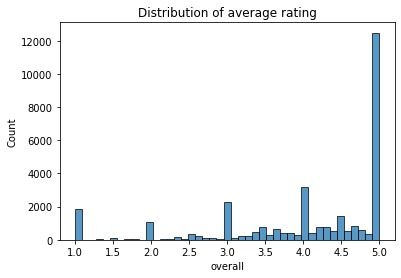

In [17]:
ratings_rate = ratings_trainings.groupby(by = 'asin')[['overall']].mean()
sns.histplot(data = ratings_rate, x = 'overall')
plt.title('Distribution of average rating')

◆ 75.9%的商品得到4分(含)以上的評分，整體商品評分偏高

Text(0.5, 1.0, 'Distribution of rating')

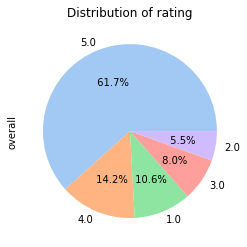

In [18]:
colors = sns.color_palette('pastel')[:5]
ratings_trainings.overall.value_counts().plot.pie(
    y = 'overall', 
    autopct=lambda p:f'{p: .1f}%',
    colors = colors 
)
plt.title('Distribution of rating')

# part_3 method comparison

◆ 將使用三種偕同過濾之方式，做推薦比較

## part_3-1 cf-user-based (recommender1)

◆ 結合user-based偕同過濾及規則推薦<br>
◆ 延續前兩周發現之結果，規則推薦採近期高分熱銷品推薦

In [19]:
import pandas as pd
from itertools import combinations
from collections import defaultdict

# header: user_id,item_id,rating,timestamp

def recommender1(training_data, users=[], k=10):

    # loading data from dataframe
    # user_to_items dict:
    # {
    #   'user': {
    #       'item': ratings...
    #   }...
    # }
#-----new user------#----ruled-based-----#
    # set time periodprice limit    
    split_date = '2018-08-01'
    condition_time = training_data[training_data['DATE']>=split_date]
    
    condition_all = condition_time.groupby(by = ['asin'], as_index=False).agg(buy_count=('asin', 'count'), rating_mean=('overall', 'mean')).sort_values(by=['buy_count', 'rating_mean'], ascending=[False, False])
    
    
#-----old user------#----cf-based-----#    
    user_to_items = defaultdict(dict)
    for _, row in training_data.iterrows():
        row = dict(row)
        user = row['reviewerID']
        item = row['asin']
        rating = float(row['overall'])

        user_to_items[user][item] = rating

    print("total users before filtering: ", len(user_to_items))

    # remove obscure user to decrease data size
    # filtering params
    remove_obscure_user = True
    user_rating_threshold = 3
    all_users = list(user_to_items.keys())
    for user in all_users:
        ratings = user_to_items[user]
        if remove_obscure_user and len(ratings) < user_rating_threshold:
            del user_to_items[user]

    print("total users  after filtering: ", len(user_to_items))

    # generate item to user mapping dict
    # {
    #   'item': {
    #       'user': ratings...
    #   }...
    # }
    item_to_users = defaultdict(dict)
    for user, items in user_to_items.items():
        for item, rating in items.items():
            item_to_users[item][user] = rating

    # prepare data of computing user similarity 
    init_sim = lambda: [0 for _ in range(3)]
    factory = lambda: defaultdict(init_sim)
    pre_user_similarity = defaultdict(factory)
    n = len(item_to_users)
    index = 0
    for item, user_ratings in item_to_users.items():
        if len(user_ratings) > 1:
            # print(f"item: {item} have been rated by {len(user_ratings)} users progress: {index}/{n}")
            for user1, user2 in combinations(user_ratings.keys(), 2):
                xy = user_ratings[user1] * user_ratings[user2]
                xx = user_ratings[user1] ** 2
                yy = user_ratings[user2] ** 2
                pre_user_similarity[user1][user2][0] += xy
                pre_user_similarity[user1][user2][1] += xx
                pre_user_similarity[user1][user2][2] += yy

                pre_user_similarity[user2][user1][0] += xy
                pre_user_similarity[user2][user1][1] += xx
                pre_user_similarity[user2][user1][2] += yy
        index += 1

    user_similarity = {}
    for src_user in pre_user_similarity:
        user_similarity_order = []
        for dst_user, val in pre_user_similarity[src_user].items(): # break出來後到這邊
            xy = val[0]
            xx = val[1]
            yy = val[2]
            div = ((xx*yy) ** 0.5)
            if div == 0: # 
                continue
            similarity = xy / div
            if similarity < 0:
                continue
            for i, s in enumerate(user_similarity_order): #s-tuple
                target_similarity = s[1] # 舊
                if target_similarity < similarity:
                    user_similarity_order.insert(i, (dst_user, similarity))
                    break
            else:
                user_similarity_order.append((dst_user, similarity))
        user_similarity[src_user] = user_similarity_order # list中tuple

    recommendation = {}
    for user in users: #testing data中的user
        if user in user_similarity:
            sim_users = user_similarity[user]
            recommended_items = []
            recommended_items_set = set()
            user_have_rated = set(user_to_items[user]) # 同產品不同評分(只想要確定他有評分、不管評分高低)
            stop_recommend = False
            for sim_user, _ in sim_users:
                items_from_sim_user = sorted(list(user_to_items[sim_user].items()), key=lambda item: item[1]) #抓最相似的使用者，在u2i中評過的item針對dict中value小到大排序
                for item, _ in items_from_sim_user: 
                    if item not in user_have_rated and item not in recommended_items_set: 
                        recommended_items.append(item)
                        recommended_items_set.add(item)
                    if len(recommended_items) >= k:
                        stop_recommend = True 
                        break 
                if stop_recommend:
                    break 
            recommendation[user] = recommended_items
        else: # 不在那38位中
            recommendation[user] = condition_all['asin'][:k].tolist()   
    return recommendation

In [20]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

In [21]:
ratings_by_user_rec1 = recommender1(ratings_trainings, users)
print(f'cf_user+rule, score = ',evaluate(ratings_testings_by_user, ratings_by_user_rec1))
print('================================')

total users before filtering:  323489
total users  after filtering:  4793
cf_user+rule, score =  0.15593220338983052


# part 2 cf-item-based (recommender2)

◆ 結合item-based偕同過濾及規則推薦<br>
◆ 延續前兩周發現之結果，規則推薦採近期高分熱銷品推薦

In [22]:
import pandas as pd
from itertools import combinations
from collections import defaultdict

def recommender2(training_data, users=[], k=10):

    # loading data from dataframe
    # item_to_users dict:
    # {
    #   'item': {
    #       'user': ratings...
    #   }...
    # }
    item_to_users = defaultdict(dict)
    for _, row in training_data.iterrows():
        row = dict(row)
        user = row['reviewerID']
        item = row['asin']
        rating = float(row['overall'])
        item_to_users[item][user] = rating

    print("data converted")

    user_to_items = defaultdict(dict)
    for item, rating_users in item_to_users.items():
        for user, rating in rating_users.items():
            user_to_items[user][item] = rating

    print("data inverted")

    init_sim = lambda: [0, 0, 0]
    factory = lambda: defaultdict(init_sim)
    pre_item_similarity = defaultdict(factory)
    for user, items in user_to_items.items():
        if len(items) > 1:
            for i1, i2 in combinations(items.keys(), 2):
                xy = items[i1] * items[i2]
                xx = items[i1] ** 2
                yy = items[i2] ** 2
                pre_item_similarity[i1][i2][0] += xy
                pre_item_similarity[i1][i2][1] += xx
                pre_item_similarity[i1][i2][2] += yy

                pre_item_similarity[i2][i1][0] += xy
                pre_item_similarity[i2][i1][1] += xx
                pre_item_similarity[i2][i1][2] += yy

    print("sim data prepared")

    item_similarity = {}
    for src_item in pre_item_similarity:
        item_similarity_order = []
        for dst_item, val in pre_item_similarity[src_item].items():
            xy = val[0]
            xx = val[1]
            yy = val[2]
            div = ((xx*yy) ** 0.5)
            if div == 0:
                continue
            similarity = xy / div
            if similarity < 0:
                continue
            for i, s in enumerate(item_similarity_order):
                target_similarity = s[1]
                if target_similarity < similarity:
                    item_similarity_order.insert(i, (dst_item, similarity))
                    break
            else:
                item_similarity_order.append((dst_item, similarity))
        item_similarity[src_item] = item_similarity_order

#     print(f"get {k} recommendation items for for user: {users}")  # 暫不印出

    recommendation = {}
    for user in users:
        items = []
        items_set = set()
        stop = False
        user_has_rated = set(user_to_items[user])
        for item in user_has_rated:
            if item in item_similarity:
                for sim_item, _ in item_similarity[item]:
                    # skip the item user has rated
                    if sim_item not in user_has_rated and sim_item not in items_set:
                        items.append(sim_item)
                        items_set.add(sim_item)
                    if len(items) >= k:
                        stop = True
                        break
                if stop:
                    break
        recommendation[user] = items
    return recommendation    

In [23]:
def recommender_combine(training_data, recommendation={}, k=10):
    """當偕同過濾無法推薦時採規則推薦"""
    split_date = '2018-08-01'
    condition_time = training_data[training_data['DATE']>=split_date]
    condition_all = condition_time.groupby(by = ['asin'], as_index=False).agg(buy_count=('asin', 'count'), rating_mean=('overall', 'mean')).sort_values(by=['buy_count', 'rating_mean'], ascending=[False, False])
    top_sales = condition_all['asin'][:k].tolist()
    
    for user, r_items in recommendation.items():
        # if recommend less than k items
        if len(r_items) < k:
            rule_based_need = k - len(r_items)
            # comebine rule-based 
            r_items = r_items + top_sales[:rule_based_need]
            recommendation[user] = r_items
    
    return recommendation   

In [24]:
ratings_by_user_rec2 = recommender2(ratings_trainings, users)
recommendation_result_item = recommender_combine(ratings_trainings,ratings_by_user_rec2)
print(f'cf_item+rule, score = ',evaluate(ratings_testings_by_user, recommendation_result_item))
print('================================')

data converted
data inverted
sim data prepared
cf_item+rule, score =  0.15254237288135594


# part 3 using_surprise (recommender3)

◆ 結合surprise模型偕同過濾及規則推薦<br>
◆ 延續前兩周發現之結果，規則推薦採近期高分熱銷品推薦

In [25]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 5.0 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619416 sha256=78153aa49a17359aebeb78840d21e23dc5c1c3782a548abb58d8ba776e1b0bbd
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [26]:
import time
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise import KNNBasic

def recommender3(training_data, users=[], k=10, user_based=False, algo=KNNBasic):

    training_data = (
        training_data
        .sort_values("DATE", ascending=False)
        .groupby(['reviewerID', 'asin']).head(1)
    )

    training_data = training_data[training_data.DATE >= '2018-01-01'] # 與規則推薦一樣皆取8個月
    
    reader = Reader(rating_scale=(0, 5))
    training_data = training_data[['reviewerID', 'asin', 'overall']]
    data = Dataset.load_from_df(training_data, reader=reader)

    sim_options = {
        'name': 'cosine',
        'user_based': user_based  # compute similarities between items
    }
    algo_impl = algo(sim_options=sim_options)
    trainset = data.build_full_trainset()
    algo_impl.fit(trainset)

    recommendation = {}
    for user in users:
        items_user_rated = set(training_data.loc[training_data['reviewerID'] == user]['asin'].to_list())
        recommend_item_list = []
        recommend_item_set = set()
        for item in items_user_rated:
            iid = algo_impl.trainset.to_inner_iid(item)
            recommend_items_iid = algo_impl.get_neighbors(iid, k)
            for sim_item_iid in recommend_items_iid:
                item_raw_id = algo_impl.trainset.to_raw_iid(sim_item_iid)
                if item_raw_id not in items_user_rated and item_raw_id not in recommend_item_set:
                    recommend_item_list.append(item_raw_id)
                    recommend_item_set.add(item_raw_id)

            if len(recommend_item_list) >= k:
                recommend_item_list = recommend_item_list[:k]
                break
        recommendation[user] = recommend_item_list

    return recommendation

In [27]:
ratings_by_user_rec3 = recommender3(ratings_trainings, users)
recommendation_result_surprise = recommender_combine(ratings_trainings,ratings_by_user_rec3)
print(f'cf_surprise+rule, score = ',evaluate(ratings_testings_by_user, recommendation_result_surprise))
print('================================')

Computing the cosine similarity matrix...
Done computing similarity matrix.
cf_surprise+rule, score =  0.15593220338983052


### 評分結果

In [28]:
# score
method1 = evaluate(ratings_testings_by_user, ratings_by_user_rec1)
method2 = evaluate(ratings_testings_by_user, recommendation_result_item)
method3 = evaluate(ratings_testings_by_user, recommendation_result_surprise)


score_result = {'method':['1','2','3'],
                'description':['cf_user+rule','cf_item+rule','cf_surprise+rule'],
                'score':[method1, method2, method3]}

df_score = pd.DataFrame(score_result)
display(df_score)

,method,description,score
0,1,cf_user+rule,0.155932
1,2,cf_item+rule,0.152542
2,3,cf_surprise+rule,0.155932
